In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os
import cv2
import warnings
warnings.filterwarnings("ignore")
import argparse
from sklearn.model_selection import ShuffleSplit
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data import Subset
import torchvision.transforms.functional as tf
import torch.optim as optim
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator

%matplotlib inline

In [3]:
import random
from PIL import Image,ImageDraw
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [4]:
import torch
np.random.seed(42)
torch.manual_seed(42)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df=pd.read_csv("/content/drive/MyDrive/Clover_single/train/_annotations.csv")
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,27932_jpg.rf.e1d494b0a56b9dfba485679f6501bba3.jpg,640,640,5-Leaf-Clovers,241,73,487,248
1,32644_jpg.rf.e02738f99ca1a8782822276fd54a25b0.jpg,640,640,4-Leaf-Clovers,223,196,371,424
2,15588_jpg.rf.e1006ef82b6a7e8f4a2d214093be4b38.jpg,640,640,4-Leaf-Clovers,286,326,471,526
3,11048_jpg.rf.e2e9100fe629d19f638205324342bdc8.jpg,640,640,4-Leaf-Clovers,274,376,446,480
4,29481_jpg.rf.e194b849632e1bd8256b6d368fbb9606.jpg,640,640,4-Leaf-Clovers,71,78,296,426


In [7]:
# Display the first few rows
print("Original DataFrame:")
print(df.head())
print("\nShape:", df.shape)

# Drop unnecessary columns
df.drop(['width', 'height', 'class'], axis=1, inplace=True)

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)

# Convert 'xmin', 'ymin', 'xmax', 'ymax' to numeric type if they aren't
numeric_columns = ['xmin', 'ymin', 'xmax', 'ymax']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Ensure bounding box coordinates are valid (xmin < xmax and ymin < ymax)
invalid_boxes = (df['xmin'] >= df['xmax']) | (df['ymin'] >= df['ymax'])
if invalid_boxes.sum() > 0:
    print(f"\nRemoving {invalid_boxes.sum()} rows with invalid bounding boxes")
    df = df[~invalid_boxes]

# Reset index after all the preprocessing steps
df.reset_index(drop=True, inplace=True)

print("\nFinal DataFrame:")
print(df.head())
print("\nFinal Shape:", df.shape)
print("\nColumn Info:")
print(df.info())

Original DataFrame:
                                            filename  width  height  \
0  27932_jpg.rf.e1d494b0a56b9dfba485679f6501bba3.jpg    640     640   
1  32644_jpg.rf.e02738f99ca1a8782822276fd54a25b0.jpg    640     640   
2  15588_jpg.rf.e1006ef82b6a7e8f4a2d214093be4b38.jpg    640     640   
3  11048_jpg.rf.e2e9100fe629d19f638205324342bdc8.jpg    640     640   
4  29481_jpg.rf.e194b849632e1bd8256b6d368fbb9606.jpg    640     640   

            class  xmin  ymin  xmax  ymax  
0  5-Leaf-Clovers   241    73   487   248  
1  4-Leaf-Clovers   223   196   371   424  
2  4-Leaf-Clovers   286   326   471   526  
3  4-Leaf-Clovers   274   376   446   480  
4  4-Leaf-Clovers    71    78   296   426  

Shape: (801, 8)

Missing values:
filename    0
xmin        0
ymin        0
xmax        0
ymax        0
dtype: int64

Final DataFrame:
                                            filename  xmin  ymin  xmax  ymax
0  27932_jpg.rf.e1d494b0a56b9dfba485679f6501bba3.jpg   241    73   487   248


In [8]:
df

,filename,xmin,ymin,xmax,ymax
0,27932_jpg.rf.e1d494b0a56b9dfba485679f6501bba3.jpg,241,73,487,248
1,32644_jpg.rf.e02738f99ca1a8782822276fd54a25b0.jpg,223,196,371,424
2,15588_jpg.rf.e1006ef82b6a7e8f4a2d214093be4b38.jpg,286,326,471,526
3,11048_jpg.rf.e2e9100fe629d19f638205324342bdc8.jpg,274,376,446,480
4,29481_jpg.rf.e194b849632e1bd8256b6d368fbb9606.jpg,71,78,296,426
...,...,...,...,...,...
796,359_jpg.rf.df48d22a662ce52a39e0db201061a758.jpg,38,12,356,525
797,27057_jpg.rf.deec3b11f711a885f8a34371a66d6756.jpg,34,164,525,437
798,16583_jpg.rf.dd4e1838971c1c86a8aea6ffc25c64a8.jpg,257,317,328,437
799,28179_jpg.rf.ddbed5b13939df607d06e360e968788f.jpg,189,223,438,366


In [9]:
unique_imgs=df.filename.unique()



In [10]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor(object):
    def __call__(self, image, target):
        image = T.functional.to_tensor(image)
        return image, target

class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
        return image, target

class RandomVerticalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
            bbox = target["boxes"]
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]
            target["boxes"] = bbox
        return image, target

class RandomRotation(object):
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, image, target):
        angle = random.uniform(-self.degrees, self.degrees)
        height, width = image.shape[-2:]
        center = ((width - 1) * 0.5, (height - 1) * 0.5)

        M = self._get_rotation_matrix(center, angle)

        image = T.functional.rotate(image, angle)

        bbox = target["boxes"]
        new_bbox = []
        for box in bbox:
            x1, y1, x2, y2 = box
            new_points = self._rotate_box(M, (x1, y1, x2, y2))
            new_bbox.append(new_points)

        target["boxes"] = torch.tensor(new_bbox, dtype=torch.float32)
        return image, target

    def _get_rotation_matrix(self, center, angle):
        angle = -angle * np.pi / 180
        alpha = np.cos(angle)
        beta = np.sin(angle)
        return np.array([
            [alpha, beta, (1 - alpha) * center[0] - beta * center[1]],
            [-beta, alpha, beta * center[0] + (1 - alpha) * center[1]]
        ])

    def _rotate_box(self, M, box):
        x1, y1, x2, y2 = box
        points = np.array([[x1, y1, 1], [x2, y2, 1], [x1, y2, 1], [x2, y1, 1]])
        new_points = (M @ points.T).T
        min_x, min_y = new_points[:, 0].min(), new_points[:, 1].min()
        max_x, max_y = new_points[:, 0].max(), new_points[:, 1].max()
        return [min_x, min_y, max_x, max_y]

class ColorJitter(object):
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.color_jitter = T.ColorJitter(brightness, contrast, saturation, hue)

    def __call__(self, image, target):
        image = self.color_jitter(image)
        return image, target


class CustData(torch.utils.data.Dataset):
    def __init__(self, folder_path, annotations_file, transform=None):
        self.folder_path = folder_path
        self.df = pd.read_csv(annotations_file)
        self.unique_imgs = self.df['filename'].unique()
        self.transform = transform

    def __len__(self):
        return len(self.unique_imgs)

    def __getitem__(self, idx):
        image_name = self.unique_imgs[idx]
        img_path = os.path.join(self.folder_path, image_name)
        img = Image.open(img_path).convert('RGB')

        # Get bounding boxes for this image
        image_data = self.df[self.df['filename'] == image_name]
        boxes = image_data[['xmin', 'ymin', 'xmax', 'ymax']].values
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = torch.tensor(boxes, dtype=torch.float32)
        target['labels'] = labels

        if self.transform:
            img, target = self.transform(img, target)

        return img, target

def get_transform(train):
    transforms = []
    transforms.append(ToTensor())
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
        transforms.append(RandomVerticalFlip(0.3))
        transforms.append(RandomRotation(15))
        transforms.append(ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1))
    return Compose(transforms)




In [11]:
# Collate function to handle batches
def custom_collate(batch):
    return tuple(zip(*batch))


train_dataset = CustData(
    '/content/drive/MyDrive/Clover_single/train',
    '/content/drive/MyDrive/Clover_single/train/_annotations.csv',
    transform=get_transform(train=False)
)
val_dataset = CustData(
    '/content/drive/MyDrive/Clover_single/valid',
    '/content/drive/MyDrive/Clover_single/valid/_annotations.csv',
    transform=get_transform(train=False)
)

# Create data loaders
train_dl = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=custom_collate
)
val_dl = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=custom_collate
)


In [12]:
def create_improved_model():
    # Load pre-trained model
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights='DEFAULT',pretrained =True)

    # 2. Increase the number of proposals
    model.rpn.pre_nms_top_n_train = 2000
    model.rpn.pre_nms_top_n_test = 1000
    model.rpn.post_nms_top_n_train = 2000
    model.rpn.post_nms_top_n_test = 1000

    # 3. Adjust NMS threshold
    model.rpn.nms_thresh = 0.5

    # 4. Modify the box detections per image
    model.roi_heads.detections_per_img = 300

    # 5. Adjust score threshold
    model.roi_heads.score_thresh = 0.05

    # Modify for clover detection
    num_classes = 2  # 1 class (clover) + background
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Create the improved model
model = create_improved_model()

# Move model to appropriate device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Print the modified model architecture
print(model)


Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 184MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): 

Epoch 1/50
  Train Loss: 199.0752, Avg Train Loss: 0.9954
Epoch 2/50
  Train Loss: 205.2803, Avg Train Loss: 1.0264
Epoch 3/50
  Train Loss: 187.9336, Avg Train Loss: 0.9397
Epoch 4/50
  Train Loss: 163.1182, Avg Train Loss: 0.8156
Epoch 5/50
  Train Loss: 160.3405, Avg Train Loss: 0.8017
Epoch 6/50
  Train Loss: 160.9498, Avg Train Loss: 0.8047
Epoch 7/50
  Train Loss: 158.4160, Avg Train Loss: 0.7921
Epoch 8/50
  Train Loss: 159.4491, Avg Train Loss: 0.7972
Epoch 9/50
  Train Loss: 154.4301, Avg Train Loss: 0.7722
Epoch 10/50
  Train Loss: 158.2801, Avg Train Loss: 0.7914
Epoch 11/50
  Train Loss: 156.5357, Avg Train Loss: 0.7827
Epoch 12/50
  Train Loss: 154.4318, Avg Train Loss: 0.7722
Epoch 13/50
  Train Loss: 157.1526, Avg Train Loss: 0.7858
Epoch 14/50
  Train Loss: 155.6690, Avg Train Loss: 0.7783
Epoch 15/50
  Train Loss: 154.6609, Avg Train Loss: 0.7733
Epoch 16/50
  Train Loss: 150.8237, Avg Train Loss: 0.7541
Epoch 17/50
  Train Loss: 153.2517, Avg Train Loss: 0.7663
Epoch 

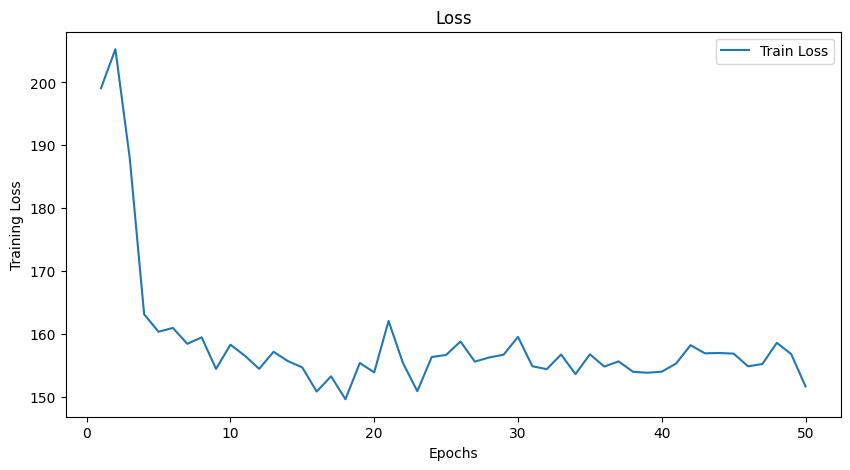

In [ ]:
from torch.optim.lr_scheduler import StepLR

def train_epoch(model, optimizer, dl, device):
    model.train()
    total_loss = 0
    num_batches = len(dl)
    for images, targets, *_ in dl:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    return total_loss, total_loss / num_batches

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else torch.device('cpu'))
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss, train_avg_loss = train_epoch(model, optimizer, train_dl, device)
    #val_loss, val_avg_loss = validate_epoch(model, val_dl, device)

    train_losses.append(train_loss)
    #val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Avg Train Loss: {train_avg_loss:.4f}")
    #print(f"  Val Loss: {val_loss:.4f}, Avg Val Loss: {val_avg_loss:.4f}")

    scheduler.step()

# Plotting code (if needed)

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
#plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Loss')
plt.legend()
plt.show()


In [ ]:

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Clover_single/single_clover_mobilenet_finale10.pth')
print("Model saved successfully!")

Model saved successfully!


In [22]:
import torch
import torchvision
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw
import pandas as pd
import os
from torchvision.ops import nms

def process_and_save_predictions(image_path, model, output_folder, output_csv_path, confidence_threshold=0.5, iou_threshold=0.5):
    model.eval()
    device = next(model.parameters()).device

    results = []

    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    img_tensor = F.to_tensor(img).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        output = model(img_tensor)[0]

        boxes = output['boxes']
        scores = output['scores']
        labels = output['labels']

        # Apply NMS
        keep = nms(boxes, scores, iou_threshold)
        boxes = boxes[keep]
        scores = scores[keep]
        labels = labels[keep]

        # Filter by confidence threshold
        mask = scores > confidence_threshold
        boxes = boxes[mask]
        scores = scores[mask]
        labels = labels[mask]

        image_name = os.path.basename(image_path)

        # Draw bounding boxes on the image
        draw = ImageDraw.Draw(img)
        for box, score, label in zip(boxes, scores, labels):
            box = box.tolist()
            draw.rectangle(box, outline="red", width=2)
            draw.text((box[0], box[1]), f"Class: {label.item()}, Conf: {score:.2f}", fill="white")

            results.append({
                'filename': image_name,
                'xmin': box[0],
                'ymin': box[1],
                'xmax': box[2],
                'ymax': box[3],
                'confidence': score.item(),
                'class': label.item()
            })

    # Save the image with bounding boxes
    output_image_path = os.path.join(output_folder, f"pred_{image_name}")
    img.save(output_image_path)
    print(f"Predicted image saved to {output_image_path}")

    return results

def process_folder(input_folder, model, device, output_folder, output_csv_path):
    all_results = []

    for image_name in os.listdir(input_folder):
        if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(input_folder, image_name)
            results = process_and_save_predictions(image_path, model, output_folder, output_csv_path)
            all_results.extend(results)

    # Save all results to CSV
    df = pd.DataFrame(all_results)
    df.to_csv(output_csv_path, index=False)
    print(f"All predictions saved to {output_csv_path}")


In [23]:

# Usage
if __name__ == "__main__":
    # Set up your model
    #model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=False, num_classes=2)
    #device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    #model.to(device)

    # Load your trained weights
    model.load_state_dict(torch.load('/content/drive/MyDrive/Clover_single/single_clover_mobilenet_finale10.pth'))

   # Specify input and output folders
    input_folder = '/content/drive/MyDrive/Clover_single/test'
    output_folder = '/content/drive/MyDrive/Clover_single/output_Mobilenet_single/'
    output_csv_path = '/content/drive/MyDrive/Clover_single/test1_single_mobilenet_final.csv'

    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Process all images in the folder
    process_folder(input_folder, model, device, output_folder, output_csv_path)

Predicted image saved to /content/drive/MyDrive/Clover_single/output_Mobilenet_single/pred_11126_jpg.rf.100d16a1fd7d2482d947b9a7fad365a5.jpg
Predicted image saved to /content/drive/MyDrive/Clover_single/output_Mobilenet_single/pred_11886_jpg.rf.999e8e81dcdf93d3c92419f4f9bbbdd6.jpg
Predicted image saved to /content/drive/MyDrive/Clover_single/output_Mobilenet_single/pred_12256_jpg.rf.1b308bd6918cce53038a45e6d20a0284.jpg
Predicted image saved to /content/drive/MyDrive/Clover_single/output_Mobilenet_single/pred_1255_jpg.rf.fdfb5f93c41640cbd8d145e2a88c48f9.jpg
Predicted image saved to /content/drive/MyDrive/Clover_single/output_Mobilenet_single/pred_13202_jpg.rf.7c8814885a16750479617aed355229dd.jpg
Predicted image saved to /content/drive/MyDrive/Clover_single/output_Mobilenet_single/pred_13528_jpg.rf.d8c8eb03f7bd0d1e7920c0ae166cd34e.jpg
Predicted image saved to /content/drive/MyDrive/Clover_single/output_Mobilenet_single/pred_14346_jpg.rf.8edc5256ace0fdff65721aad994ebea3.jpg
Predicted imag

In [19]:
import glob as glob
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(6, 6))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

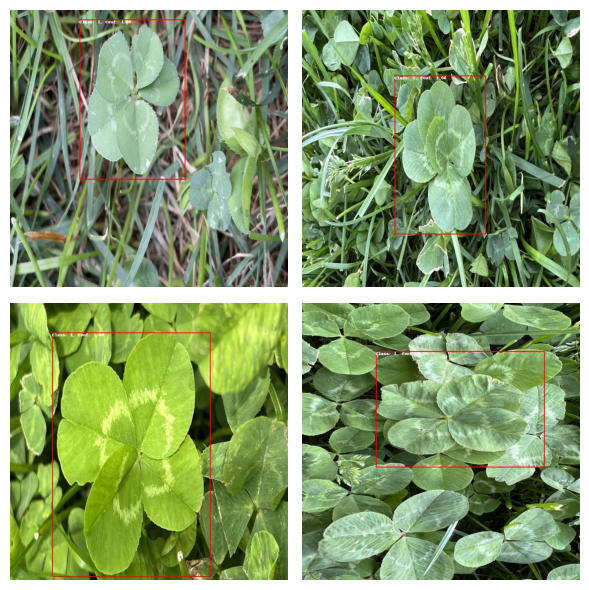

In [20]:
visualize('/content/drive/MyDrive/Clover_single/output_final')